# TripAdvisor Seoul LDA Topic Modeling (All Reviews)

In [1]:
import pandas as pd
import numpy as np

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [2]:
data = pd.read_csv("Sentiment_Scores_TripAdvisor_English_Reviews_Seoul_Hotels.csv")
data.head()

Hotel   reviewer_name    country  rating   date_of_stay  \
0  9Brick_Hotel    ChristelleNg  Singapore     4.0  December 2022   
1  9Brick_Hotel        Molly123        NaN     1.0  December 2022   
2  9Brick_Hotel     wamysdottir    Denmark     4.0   October 2019   
3  9Brick_Hotel  worldtraveller        NaN     3.0  December 2019   
4  9Brick_Hotel       Hui Yingg  Australia     4.0  November 2019   

  date_review_written                                      clean_reviews  \
0            Jan 2023  Love the look Location not too bad. Near the H...   
1            Dec 2022  Very bad experience I asked the hotel to provi...   
2            Apr 2020  Chic design A clean boutique hotel convenientl...   
3            Dec 2019  Great location but weak service standards Let ...   
4            Nov 2019  Never better This hotel exceeded my expectatio...   

   clean_reviews Positive Sentiment Score  \
0                                   0.184   
1                                   0.154   
2                                   0.157   
3                                   0.140   
4                                   0.156   

   clean_reviews Negative Sentiment Score  \
0                                   0.092   
1                                   0.156   
2                                   0.000   
3                                   0.087   
4                                   0.020   

   clean_reviews Neutral Sentiment Score  \
0                                  0.724   
1                                  0.690   
2                                  0.843   
3                                  0.774   
4                                  0.823   

   clean_reviews Compound Sentiment Score sentiment  word_count  \
0                                  0.6543  Positive          48   
1                                 -0.2752   Neutral          51   
2                                  0.9001  Positive          81   
3                                  0.9451  Positive         240   
4                                  0.9778  Positive         170   

   word_count_scaled                               preprocessed_reviews  
0          -0.659063  love look location bad station comfortable bed...  
1          -0.634015  bad experience ask provide set comfort refuse ...  
2          -0.383532  chic design clean boutique conveniently locate...  
3           0.944029  location weak service standard let start like ...  
4           0.359568  never well exceed expectation term efficient s...

In [3]:
def gen_words(texts):
    return gensim.utils.simple_preprocess(texts, deacc = True)

In [4]:
reviews = data["preprocessed_reviews"]

In [5]:
reviews_tokenized = reviews.apply(gen_words)
reviews_tokenized[:5]

0    [love, look, location, bad, station, comfortab...
1    [bad, experience, ask, provide, set, comfort, ...
2    [chic, design, clean, boutique, conveniently, ...
3    [location, weak, service, standard, let, start...
4    [never, well, exceed, expectation, term, effic...
Name: preprocessed_reviews, dtype: object

In [6]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(reviews_tokenized, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[reviews_tokenized], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return([bigram_mod[doc] for doc in texts])

def make_trigrams(texts):
    return([trigram_mod[bigram_mod[doc]] for doc in texts])

In [7]:
data_bigrams = make_bigrams(reviews_tokenized)
data_bigrams_trigrams = make_trigrams(reviews_tokenized)

### Creating TF-IDF Vectorizer

In [8]:
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

In [9]:
tfidf = TfidfModel(corpus, id2word = id2word)

# After running TFIDF you can retrieve a list of low value words and remove them:

low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] 
    # The words with tf-idf socre 0 will be missing
    ## you can check this line, if you want to see if valuables words are not dropped
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i] = new_bow

In [38]:
#Modeling

lda_model = gensim.models.ldamodel.LdaModel(
corpus = corpus,
id2word = id2word,
num_topics = 3,
random_state = 100,
passes = 10) 

### Evaluating Model: Perplexity and Coherence Scores

In [11]:
perplexity_values = []

for i in range (2,30):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                                id2word = id2word,
                                                num_topics = i,
                                                random_state = 100,
                                                passes = 10)
    perplexity_values.append(lda_model.log_perplexity(corpus))

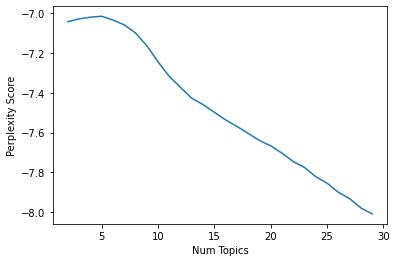

In [12]:
import matplotlib.pyplot as plt 
x = range(2,30)
plt.plot(x,perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [39]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams_trigrams, dictionary=id2word , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.399868238135008


In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,passes = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [41]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=30)

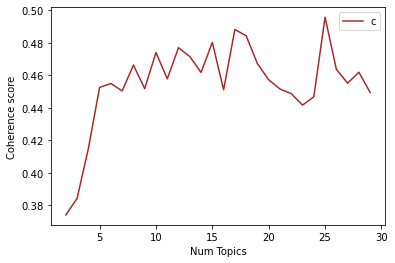

<Figure size 432x288 with 0 Axes>

In [42]:
# Show graph

import matplotlib.pyplot as plt

limit=30; start=2; step=1

x = range(start, limit, step)
plt.plot(x, coherence_values,color="brown")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('coherence_values.png',dpi=1200)

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2904
Num Topics = 3  has Coherence Value of 0.2944
Num Topics = 4  has Coherence Value of 0.3249
Num Topics = 5  has Coherence Value of 0.3364
Num Topics = 6  has Coherence Value of 0.328
Num Topics = 7  has Coherence Value of 0.344
Num Topics = 8  has Coherence Value of 0.3341
Num Topics = 9  has Coherence Value of 0.3717
Num Topics = 10  has Coherence Value of 0.3179
Num Topics = 11  has Coherence Value of 0.3467
Num Topics = 12  has Coherence Value of 0.3577
Num Topics = 13  has Coherence Value of 0.3577
Num Topics = 14  has Coherence Value of 0.3509
Num Topics = 15  has Coherence Value of 0.3688
Num Topics = 16  has Coherence Value of 0.3769
Num Topics = 17  has Coherence Value of 0.366
Num Topics = 18  has Coherence Value of 0.3593
Num Topics = 19  has Coherence Value of 0.384
Num Topics = 20  has Coherence Value of 0.3815
Num Topics = 21  has Coherence Value of 0.3695
Num Topics = 22  has Coherence Value of 0.3914
Num Topics = 23  has Cohe

In [10]:
lda_model = gensim.models.ldamodel.LdaModel(
corpus = corpus,
id2word = id2word,
num_topics = 9,
random_state = 100,
passes = 10) #passes = epochs

In [11]:
lda_model.save("AllTripAdvisorLDAmodel")

In [12]:
lda_model = gensim.models.LdaModel.load('AllTripAdvisorLDAmodel')

In [13]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = 'mmds', R = 30)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.191260  0.058675       1        1  19.002582
6      0.109094  0.054902       2        1  18.071859
5      0.020133 -0.091618       3        1  16.276477
0     -0.092463 -0.314736       4        1  11.921185
7      0.005972  0.335550       5        1   9.789582
1     -0.253943 -0.187128       6        1   8.752114
4     -0.249845  0.242724       7        1   8.130277
8      0.359616  0.177469       8        1   4.701503
3      0.292697 -0.275837       9        1   3.354421, topic_info=      Term          Freq         Total Category  logprob  loglift
119   room  33794.000000  33794.000000  Default  30.0000  30.0000
125   stay  37953.000000  37953.000000  Default  29.0000  29.0000
67   staff  23061.000000  23061.000000  Default  28.0000  28.0000
44   check  12876.000000  12876.000000  Default  27.0000  27.0000
68    walk  18851.000000  18851.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
409    use    658.008572   8750.514249   Topic9  -4.8465   0.8072
31   hotel    609.361397   6761.399850   Topic9  -4.9233   0.9883
395   free    592.074459   8154.921240   Topic9  -4.9521   0.7721
195    new    533.976866   4900.587269   Topic9  -5.0554   1.1781
9     food    582.567991  11362.860582   Topic9  -4.9683   0.4242

[676 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4581      4  0.985861     abalone
3296      7  0.994832        abit
1305      1  0.190685  absolutely
1305      3  0.024604  absolutely
1305      4  0.228151  absolutely
...     ...       ...         ...
878       4  0.192574        year
878       6  0.143812        year
878       7  0.003533        year
878       9  0.305999        year
8397      1  0.990685        yoga

[1690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 1, 8, 2, 5, 9, 4])

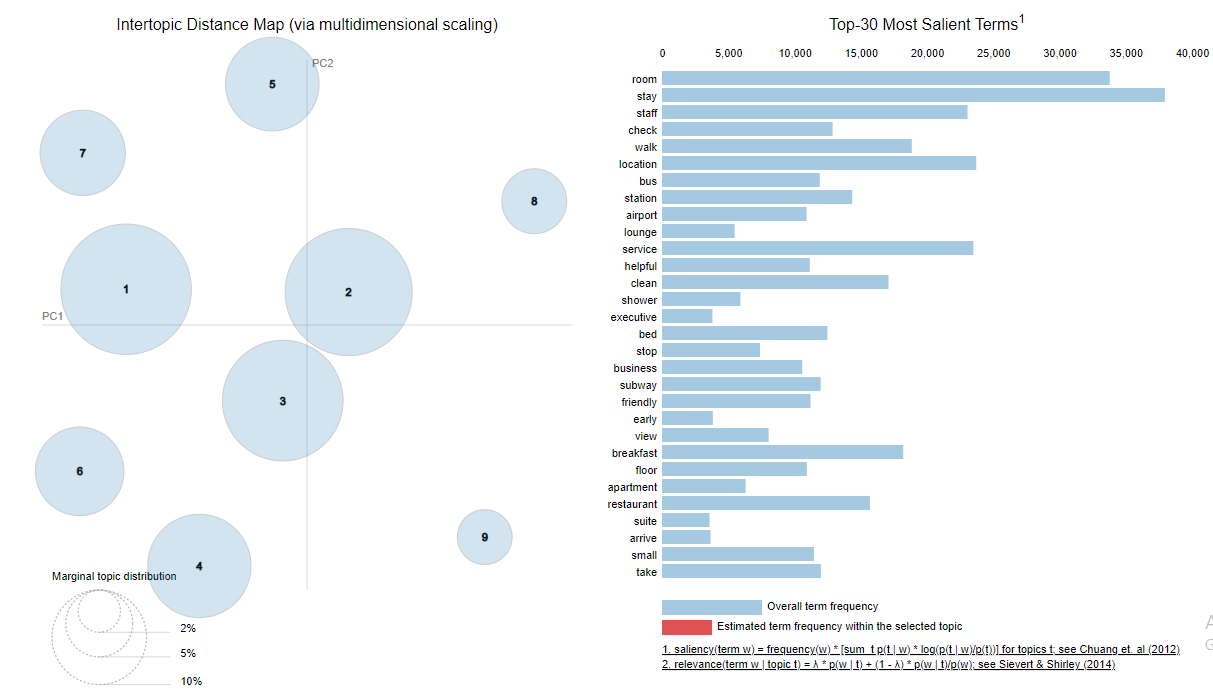

In [14]:
from IPython.display import Image
Image(filename='LDAAllreviews.png') 

In [15]:
lda_model.print_topics(num_words=15)

[(0,
  '0.127*"stay" + 0.077*"staff" + 0.031*"location" + 0.029*"service" + 0.025*"helpful" + 0.025*"friendly" + 0.024*"clean" + 0.016*"comfortable" + 0.016*"recommend" + 0.015*"time" + 0.014*"place" + 0.012*"night" + 0.011*"visit" + 0.011*"trip" + 0.010*"help"'),
 (1,
  '0.025*"view" + 0.018*"good" + 0.018*"pool" + 0.016*"service" + 0.015*"amazing" + 0.014*"food" + 0.013*"beautiful" + 0.010*"gym" + 0.010*"also" + 0.010*"city" + 0.010*"enjoy" + 0.010*"breakfast" + 0.009*"spa" + 0.009*"make" + 0.009*"restaurant"'),
 (2,
  '0.014*"get" + 0.014*"go" + 0.012*"make" + 0.011*"service" + 0.010*"say" + 0.010*"time" + 0.010*"day" + 0.008*"ask" + 0.008*"take" + 0.008*"taxi" + 0.008*"desk" + 0.008*"front" + 0.008*"call" + 0.007*"find" + 0.007*"give"'),
 (3,
  '0.065*"lounge" + 0.045*"executive" + 0.032*"club" + 0.032*"suite" + 0.028*"property" + 0.021*"service" + 0.020*"upgrade" + 0.018*"floor" + 0.014*"access" + 0.014*"marriott" + 0.013*"level" + 0.012*"hour" + 0.010*"year" + 0.010*"business" + 

In [16]:
for idx, topic in lda_model.show_topics(formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 
Words: stay|staff|location|service|helpful|friendly|clean|comfortable|recommend|time|place|night|visit|trip|help|good|back|family|also|next|thank|always|make|spacious|come|convenient|love|breakfast|highly|enjoy
Topic: 1 
Words: view|good|pool|service|amazing|food|beautiful|gym|also|city|enjoy|breakfast|spa|make|restaurant|love|fantastic|wonderful|experience|park|feel|buffet|floor|sauna|bar|home|visit|place|time|go
Topic: 2 
Words: get|go|make|service|say|time|day|ask|take|taxi|desk|front|call|find|give|first|help|guest|know|want|tell|back|see|star|think|come|hotel|use|try|way
Topic: 3 
Words: lounge|executive|club|suite|property|service|upgrade|floor|access|marriott|level|hour|year|business|drink|member|offer|apartment|snack|use|guest|bedroom|gym|hotel|happy|free|chosun|food|evening|new
Topic: 4 
Words: room|bed|night|small|floor|clean|window|sleep|get|open|bit|noise|bathroom|book|however|bad|temperature|change|smell|big|quite|size|view|time|still|day|double|air|overall|price

In [19]:
# Get the topic probabilities for each review
reviews = data['clean_reviews'].tolist()
reviews_bow = [lda_model.id2word.doc2bow(review.split()) for review in reviews]
reviews_topics = [lda_model[review] for review in reviews_bow]

# Assign each review to the topic with the highest probability
topic_labels = [max(review, key=lambda x: x[1])[0] for review in reviews_topics]

# Add the topic label as a new column in the dataset
data['topic_label'] = topic_labels

In [21]:
data.sample(4)

Hotel  reviewer_name      country  rating  \
31680               Metro_Hotel       Pamela T          NaN     4.0   
14206          Hotel_Cappuccino            Kat  South Korea     4.0   
44370  Staz_Hotel_Myeongdong_II     Angelina Y          NaN     5.0   
39422        Prince_Hotel_Seoul  Gabriel_Thong    Singapore     5.0   

        date_of_stay date_review_written  \
31680       May 2012            May 2012   
14206      July 2016            Aug 2016   
44370  December 2015            Jan 2016   
39422  February 2014            Feb 2014   

                                           clean_reviews  \
31680  Good location and reasonably priced Room is sp...   
14206  1 night at Hitel Cappuccino I stayed at Hitel ...   
44370  Great value and location Everything was excell...   
39422  A choice of hotel in Myeong Dong that will nev...   

       clean_reviews Positive Sentiment Score  \
31680                                   0.247   
14206                                   0.151   
44370                                   0.333   
39422                                   0.205   

       clean_reviews Negative Sentiment Score  \
31680                                   0.000   
14206                                   0.019   
44370                                   0.077   
39422                                   0.044   

       clean_reviews Neutral Sentiment Score  \
31680                                  0.753   
14206                                  0.830   
44370                                  0.590   
39422                                  0.751   

       clean_reviews Compound Sentiment Score sentiment  word_count  \
31680                                  0.9468  Positive          55   
14206                                  0.9838  Positive         204   
44370                                  0.9661  Positive          54   
39422                                  0.8735  Positive          57   

       word_count_scaled                               preprocessed_reviews  \
31680          -0.600617  location reasonably price room spacious modern...   
14206           0.643449  night cappuccino stay hitel cappuccino night c...   
44370          -0.608966  value location location minute walk less shopp...   
39422          -0.583918  choice never go wrong service staff accommodat...   

       topic_label  
31680            6  
14206            6  
44370            7  
39422            0

In [22]:
data.to_csv("Complete_Sentiment_Scores_TripAdvisor_English_Reviews_Seoul_Hotels.csv", index = False)

In [2]:
data = pd.read_csv("Complete_Sentiment_Scores_TripAdvisor_English_Reviews_Seoul_Hotels.csv")

In [3]:
## Dividing the data based on topic labels:

topic0 = data[data['topic_label']== 0]
topic1 = data[data['topic_label']== 1]
topic2 = data[data['topic_label']== 2]
topic3 = data[data['topic_label']== 3]
topic4 = data[data['topic_label']== 4]
topic5 = data[data['topic_label']== 5]
topic6 = data[data['topic_label']== 6]
topic7 = data[data['topic_label']== 7]
topic8 = data[data['topic_label']== 8]

In [8]:
# Word cloud of all the reviews

import matplotlib.pyplot as plt

from wordcloud import WordCloud

def plot_wordcloud(series,output_filename='wordcloud'):
    
    wordcloud = WordCloud(collocations = False,
                          background_color = "white",
                          width=1600,
                          max_words = 50,
                          height=800, 
                          margin=2,
                          min_font_size=20).generate(' '.join(series.astype(str)))

    wordcloud.to_file(output_filename + '.png')
    
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,output_filename,fontsize = 60, ha='center')
    return plt.show()

In [9]:
df_list = [topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8]
topics = ["T0","T1","T2","T3","T4","T5","T6","T7","T8"]

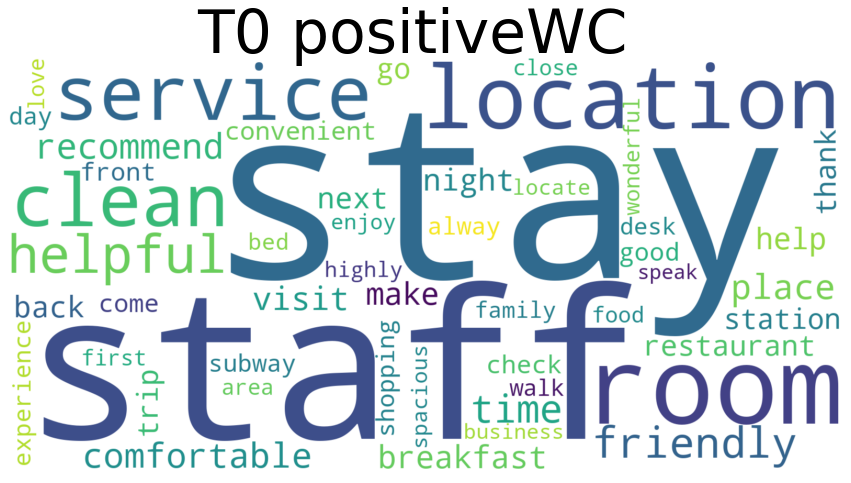

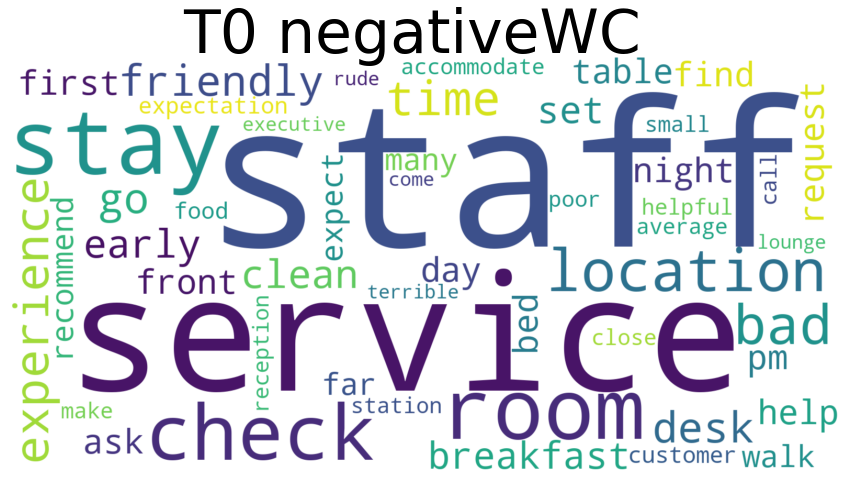

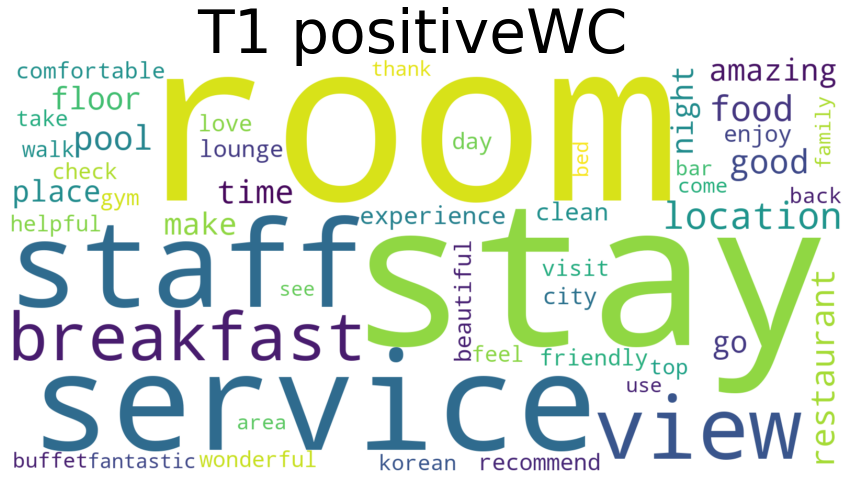

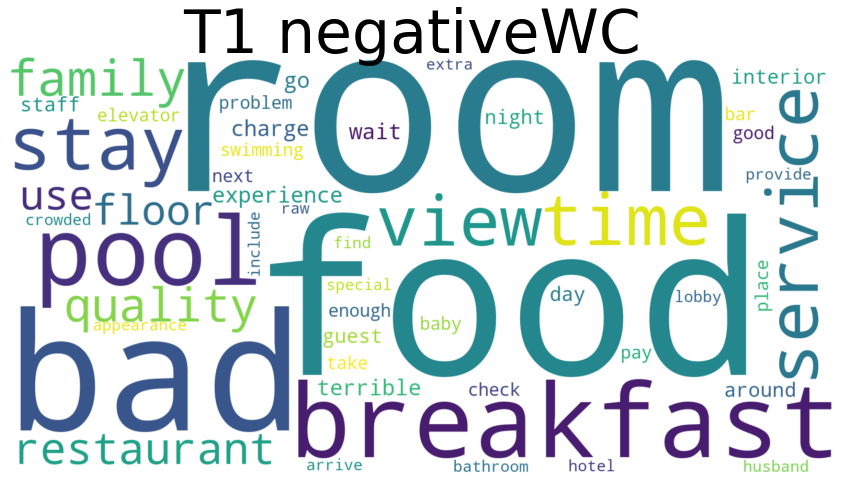

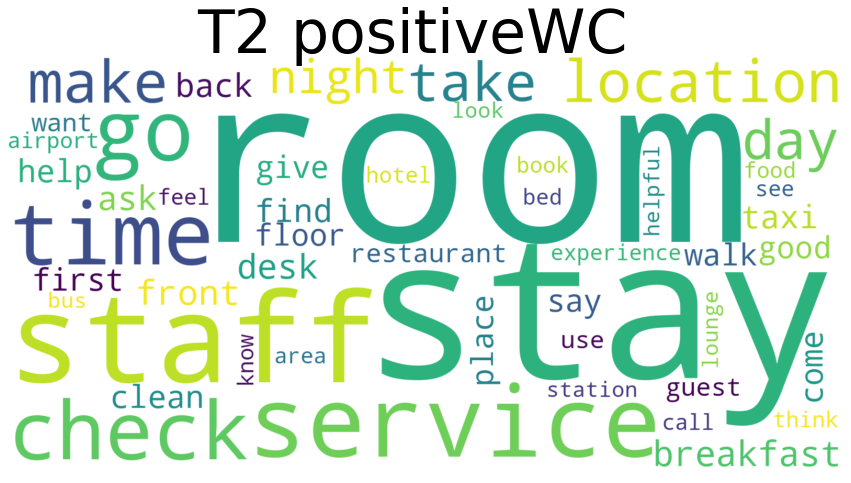

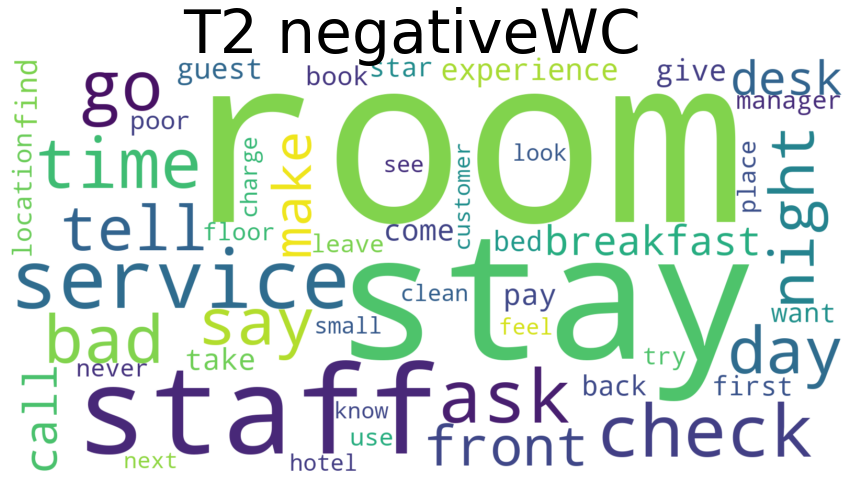

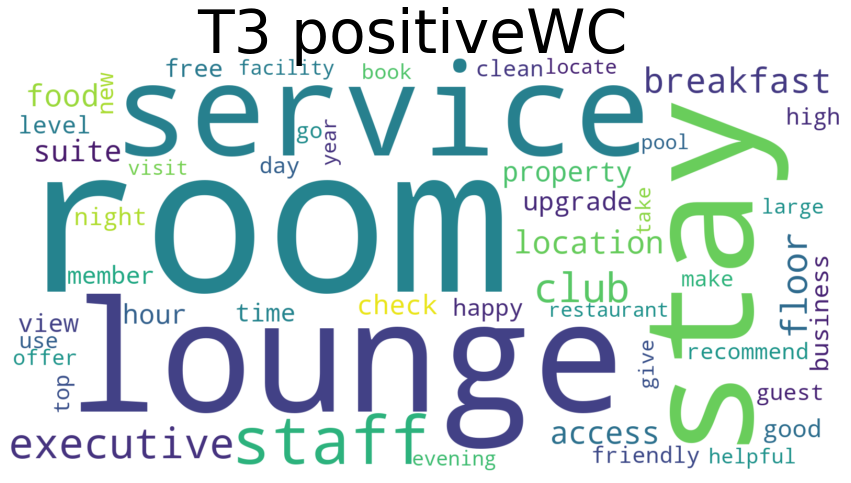

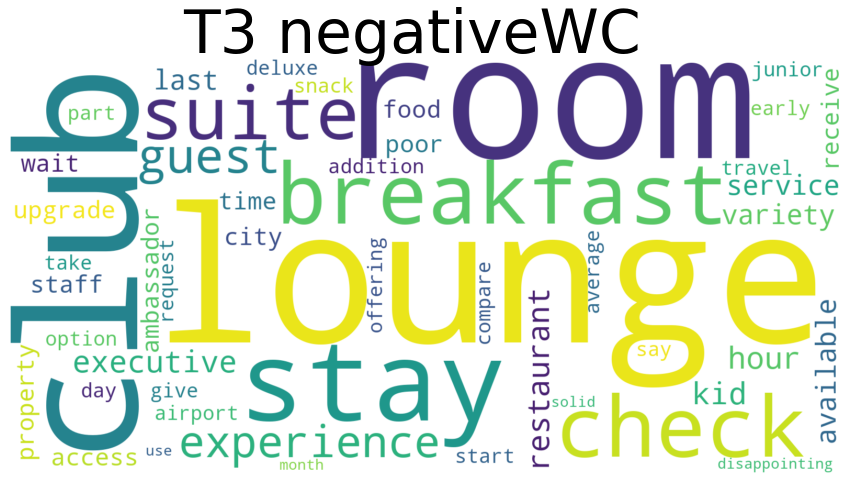

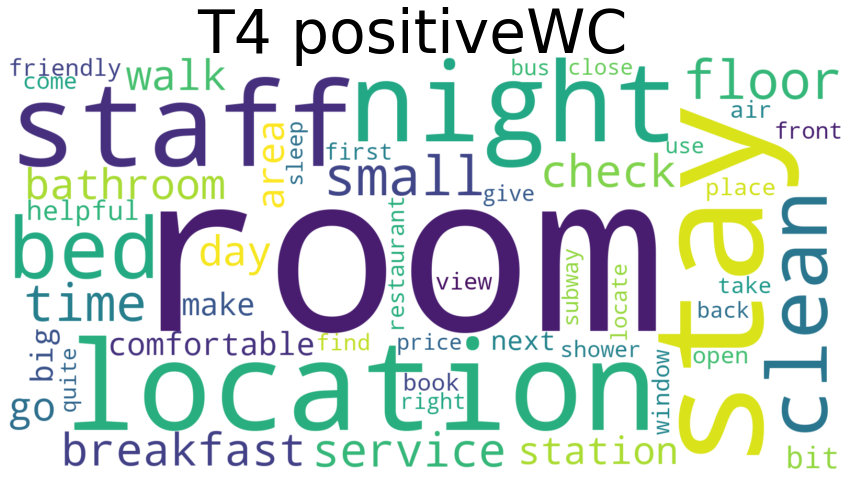

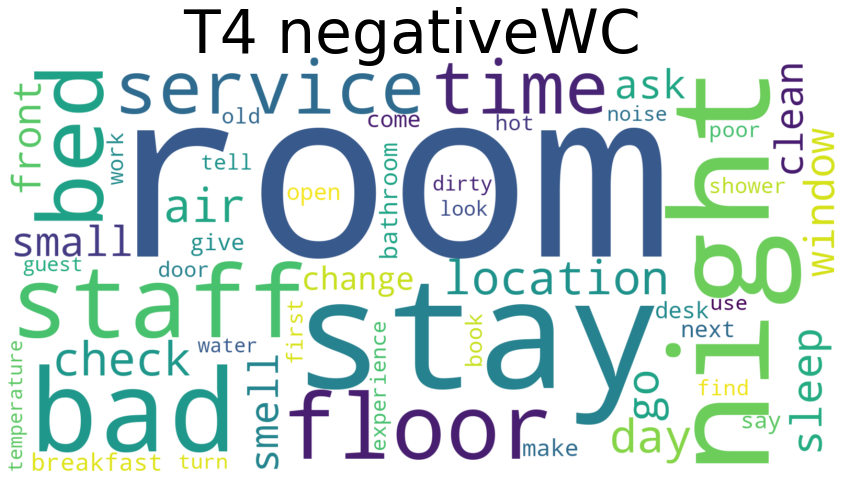

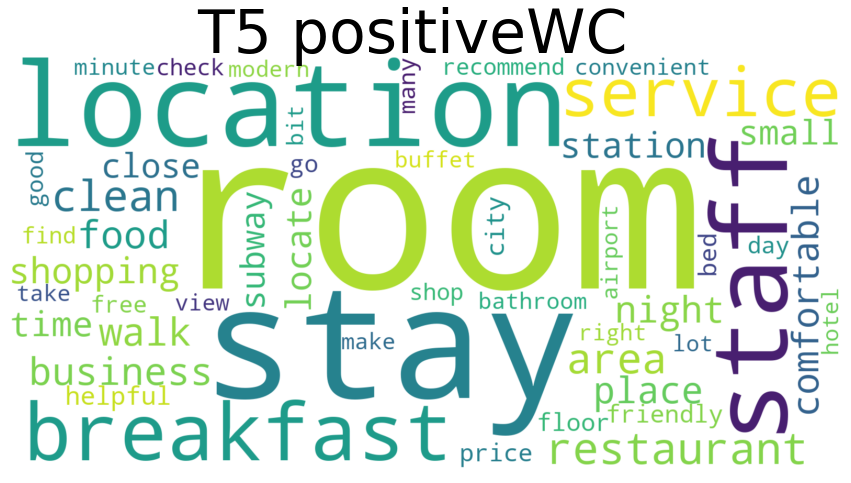

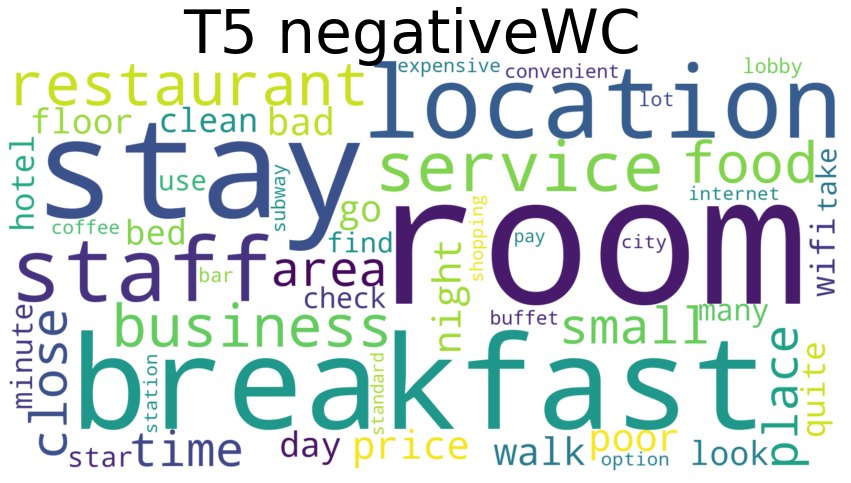

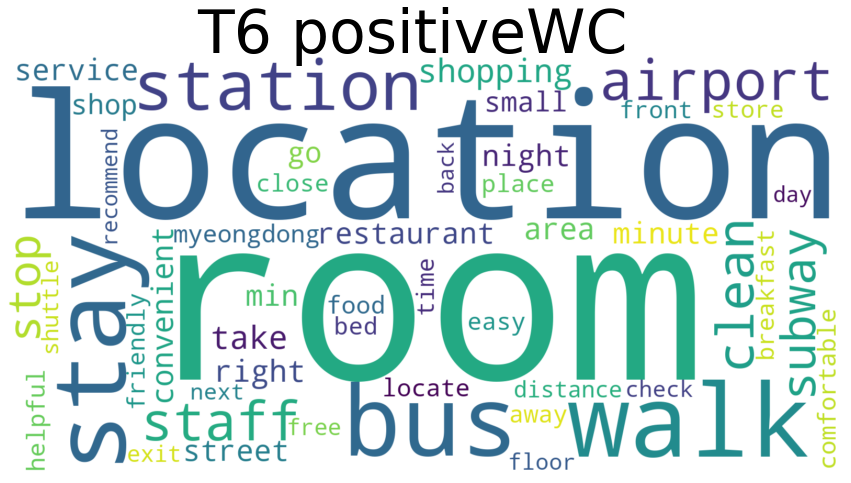

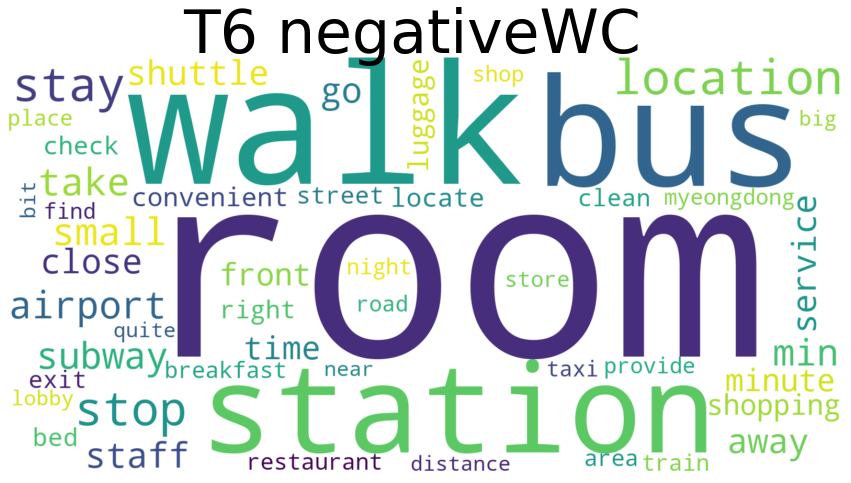

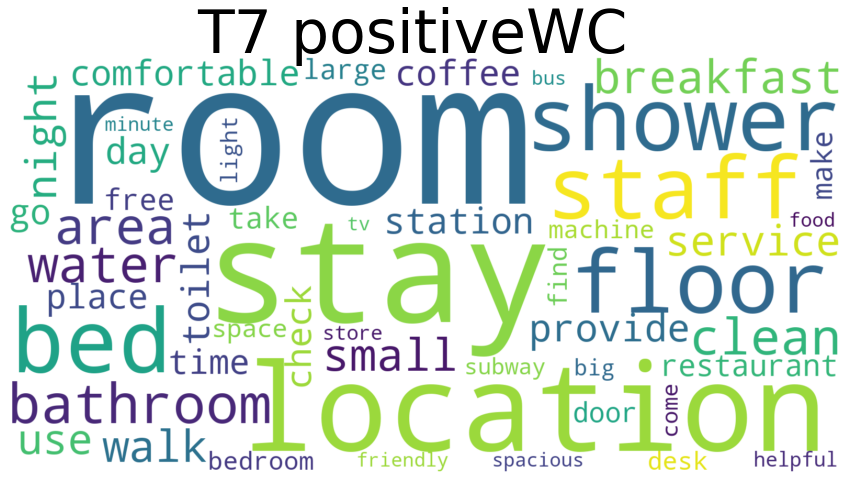

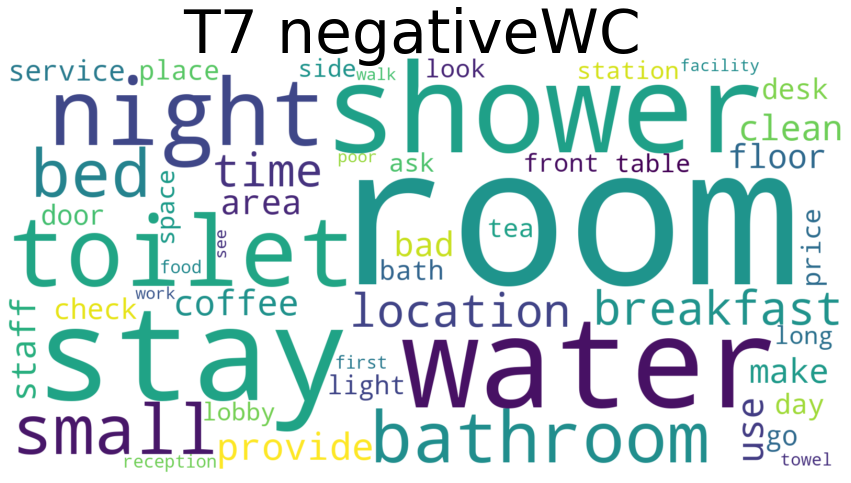

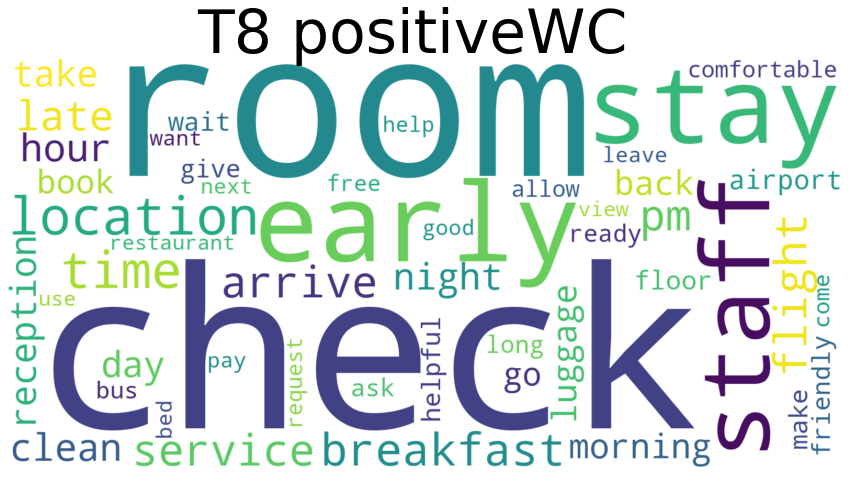

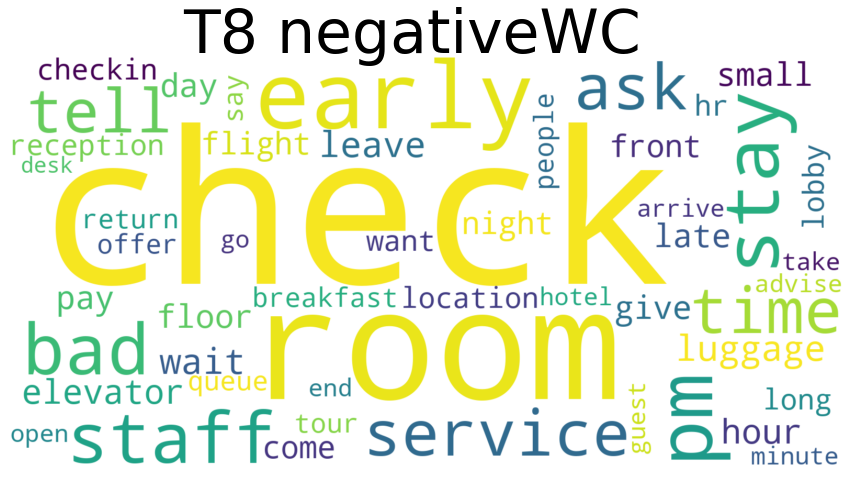

In [10]:
for df,topic in zip(df_list,topics):
    positive_df = df[df['sentiment']=='Positive'] 
    negative_df = df[df['sentiment']=='Negative']
    plot_wordcloud(positive_df["preprocessed_reviews"],f'{topic} positiveWC')
    plot_wordcloud(negative_df["preprocessed_reviews"],f'{topic} negativeWC')